# Want to calculate the moments of different power spectra

In [77]:
#set up and fixed power spectra to work with (based on 2019-07-18 Synch maps spatial variation)


#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


In [78]:
"""
----Notation used in this notebook----

ells    - the ells up to ell_max = 384
pcls    - the power law C_ell defined through pcls = (ell/80)^alpha_BB
check_cls - the extracted C_ell from a map using anafast

sbb     - the power law map in ell. This will be used for all complete maps, as we're only modifying the frequency dep.


sed_scaling_<x> - the scaled_synch function on frequencies and some beta. Up to unit conversion this is (nu/nu_0)^beta
                  where beta is either just a constant or is a whole map of betas


newmaps_<x>    - newmaps_<x> = sbb * sed_scaling_<x>. This is a series of 'real' frequency maps

""";

In [79]:
#define C_ell with a power law dependence on ell
#pcls for Power law C_Ls
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#shift the ells to start at 0
#ells = ells-1


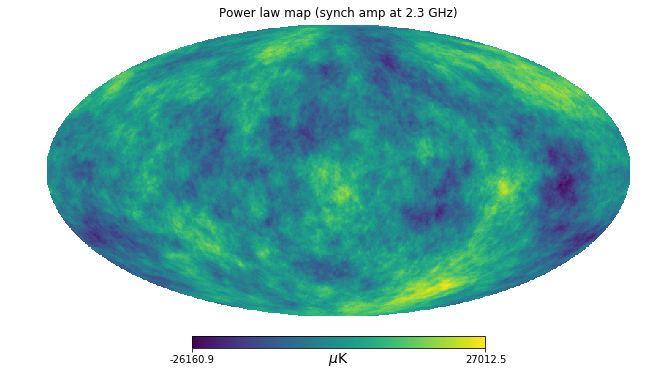

In [80]:
#-----AMPLITUDE MAP----------
sbb = hp.synfast(pcls, nside, new=True, verbose=False)
hp.mollview(sbb, unit=r'$\mu \rm K$', title='Power law map (synch amp at 2.3 GHz)')



In [81]:
#----AMPLITUDE MAP---------------------------
#these are the amplitude cls
check_pcls = hp.anafast(sbb)

In [82]:
#SED maps---constant beta-------

#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9

#define the SED scaling
sed_scaling = scale_synch(freqs, beta_BB)

#the maps including SED at different frequencies
newmaps = sbb * sed_scaling[..., np.newaxis]


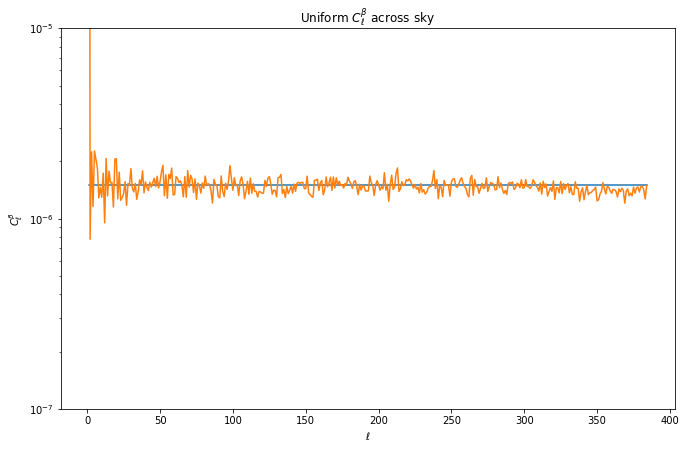

In [83]:
#varying beta
beta_sigma = 1.5e-6

#define a 'beta map' using uniform C_ell
bcls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(bcls, nside, new=True, verbose=False)
#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)


#drawn out beta cls
check_bcls = hp.anafast(beta_map)

figure(figsize=(11,7))
semilogy(ells, bcls)
semilogy(ells, check_bcls)
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Uniform $C_\ell^\beta$ across sky");


In [84]:
#make series of beta maps
sed_scaling_beta = scale_synch(freqs, beta_map).T

#make ''realistic maps'' from sbb*new SED
newmaps_beta = sbb * sed_scaling_beta

In [85]:
'''
Maps made at this stage:

Frequency amplitude maps -- in paper called Sy -- in code called sbb
Beta map -- in paper called beta_s -- in code called beta_map
Realistic maps -- in code called newmaps, newmaps_beta
''';

In paper, equation (35):
$$
C_\ell^{\nu_1\nu_2}(1\times 1) = \partial_{\beta_s}\mathrm{Sy}^{\nu_1}\partial_{\beta_s}\mathrm{Sy}^{\nu_2}\underbrace{\sum_{\ell_1\ell_2}\frac{(2\ell_1+1)(2\ell_2+1)}{4\pi}\begin{pmatrix} \ell & \ell_1 & \ell_2 \\ 0 & 0 & 0 \end{pmatrix}^2 \langle \mathrm{Sy}\mathrm{Sy}\rangle_{\ell_1}\langle \beta_s \beta_s \rangle_{\ell_2}}_{\texttt{wignersum}}
$$

In terms of code parameters
$$
C_\ell^{\nu_1\nu_2}(1\times 1) = \partial_{\beta_s}\mathrm{SED}^{\nu_1}\partial_{\beta_s}\mathrm{SED}^{\nu_2} \sum_{\ell_1\ell_2} \mathrm{normalisation} * (W^{\ell,\ell_1,\ell_2}_{0,0,0})^2 * \texttt{check_pcls[ell_1]} * \texttt{check_bcls[ell_2]}
$$

Now as we model the SED as a power law in $\beta$ we can write:
$$
\partial_\beta \mathrm{SED}(\nu) = \ln\left(\frac{\nu}{\nu_0}\right) \times \mathrm{SED}(\nu)
$$

In [86]:
from pyshtools.utils import Wigner3j

In [87]:
       '''
        to find the symbol / i ell1 ell2 \
                           \ 0  0    0   /
        for a particular i, we check that i is in the range of [ellmin, ellmax]. If it isn't, then
        this symbol is 0. If it is, then it is at the (i-ellmin)th position in the array w3j given by the Wigner 3j
        function. e.g. The symbol
        / ell 2  2 \
        \ 0   0  0 /
        produces a w3j of 
        
        [ 0.4472136   0.         -0.23904572  0.          0.23904572]
        
        (ell = 0      ell = 1     ell = 2     ell = 3     ell = 4)
        as the ellmin,ellmax is 0,4 for these symbols. Thus 
        / 2 2 2 \
        \ 0 0 0 / = -0.23904572 etc
        ''';

In [120]:
#check the runtime of the code
import time
start = time.time()


miniells = np.arange(384)
wignersum = np.zeros_like(miniells, dtype=float)

for ell1 in miniells:
    for ell2 in miniells:
        
        #-----calculate the wigner coefficients-------
        
        #finds all the non-zero wigner 3j coefficients compatible with the other 5 numbers
        #returns w3j, an array of these 3j coeff, ellmin, the j corresponding to the first non-zero of w3j, 
        #ellmax, the j corresponding to the last non-zero of w3j
        w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0)
        avaliable_ells = np.arange(ellmin, ellmax+1)

        #this block forces all the w3j arrays to have the same size as the wignersum array
        #cut off trailing zeros at the end of w3j
        max_nonzero_index = ellmax - ellmin 
        w3j = w3j[:max_nonzero_index + 1]
        
        r'''w3j = [w3j[0], w3j[1], ... , w3j[n]] with w3j[n] != 0 at this stage''' 
    
        #make the w3j array the same shape as the wignersum array
        if len(w3j) < len(miniells):
            #if the w3j is shorter than the input ells, then pad to the end with zeros
            padding = np.zeros(len(wignersum)-len(w3j))
            w3j = np.append(w3j, padding)
        else:
            w3j=w3j
           
        #roll stuff into position and relabel those that roll ''around'' to 0
        w3j = np.roll(w3j, ellmin)
        w3j[:ellmin] = np.zeros_like(w3j[:ellmin])
        
        r'''w3j = [0, 0, ... , w3j[0-ellmin], w3j[1-ellmin], ...] '''
        
        #cut to size of the moment that we're adding (the size of the ells matrix)
        w3j = w3j[:len(miniells)]
        #----------------------------------------
        
        
        #-------maps and normalisation-----------
        #define the normalisation factor in above equation
        factor = (2 * ell1 + 1)*(2 * ell2 + 1)/(4*pi)
    
        #the auto spectra are from the C_ells calculated earlier in this notebook
        #need to put these in the correct places
        synch_cls = check_pcls[ell1]
        beta_cls = check_bcls[ell2]
        #------------------------------------------


        #define wignersum to be the array with the sum of the squares of the wigner coefficients
        wignersum += w3j**2 * factor * synch_cls * beta_cls
  
        #this code is slower but definitely correct, use to check for small ell that answers agree
#         for i in range(len(miniells)):
#             if i not in avaliable_ells:
#                 wignersum[i] += 0.
#             else:
#                 w3j_i = w3j[i-ellmin]
#                 wignersum[i] += w3j_i**2

#         print("(ell1,ell2) = (" + str(ell1) + ',' +str(ell2) + ')')
#         print('w3j = ')
#         print(w3j)
#         #print("ellmin--ellmax = " +str(ellmin) +'--' + str(ellmax))
#         print('avaliable ell = ' +str(np.arange(ellmin, ellmax+1)))
#         print("")
         
end = time.time()
print(end - start)

10.524878978729248


In [125]:
# #write function to get the wigner sum given an upper bound on the sum, and the length of ells of interest
# def get_wigner(upper_ell, ells):
#     miniells = np.arange(upper_ell-1)
#     wignersum = np.zeros_like(miniells, dtype=float)
    
#     for ell1 in miniells:
#         for ell2 in miniells:
        
#             #-----calculate the wigner coefficients-------

#             #finds all the non-zero wigner 3j coefficients compatible with the other 5 numbers
#             #returns w3j, an array of these 3j coeff, ellmin, the j corresponding to the first non-zero of w3j, 
#             #ellmax, the j corresponding to the last non-zero of w3j
#             w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0)
#             avaliable_ells = np.arange(ellmin, ellmax+1)

#             #this block forces all the w3j arrays to have the same size as the moment1x1 array
#             #cut off trailing zeros at the end of w3j
#             max_nonzero_index = ellmax - ellmin 
#             w3j = w3j[:max_nonzero_index + 1]
#             print(wignersum.shape)

#             #make the w3j array the same shape as the wignersum array
#             if len(w3j) < len(miniells):
#                 #if the w3j is shorter than the input ells, then pad to the end with zeros
#                 padding = np.zeros(len(wignersum)-len(w3j))
#                 w3j = np.append(w3j, padding)
#             else:
#                 w3j=w3j

#             #roll stuff into position and relabel those that roll ''around'' to 0
#             w3j = np.roll(w3j, ellmin)
#             w3j[:ellmin] = np.zeros_like(w3j[:ellmin])
#             #cut to size of the moment that we're adding (the size of the ells matrix)
#             w3j = w3j[:len(ells)]
#             #----------------------------------------


#             #-------maps and normalisation-----------
#             #define the normalisation factor in above equation
#             factor = (2 * ell1 + 1)*(2 * ell2 + 1)/(4*pi)

#             #the auto spectra are from the C_ells calculated earlier in this notebook
#             if ell1 in ells[:len(ells)-1] and ell2 in ells[:len(ells)-1]:
#                 synch_cls = check_pcls[ell1]
#                 beta_cls = check_bcls[ell2]
#             else:
#                 synch_cls = 0
#                 beta_cls = 0
#             #------------------------------------------


#             #define X to be the array with the sum of the squares of the wigner coefficients
#             #wignersum += w3j**2 * factor * synch_cls * beta_cls

#     return wignersum


In [122]:
#todo with this code

#the sums on the ell1 and ell2 should possibly go further than the ells that we're considering? Need to 
#redo some of the sizes to make that work

#---I think the limits on the sum are actually okay, as the coefficients from the map are 0 if we're out of range----

#plot moment1x1 vs ell and try adding it to see if we move towards correct


In [ ]:
#plot wigner coeffs vs ell summed over ell1 and ell2

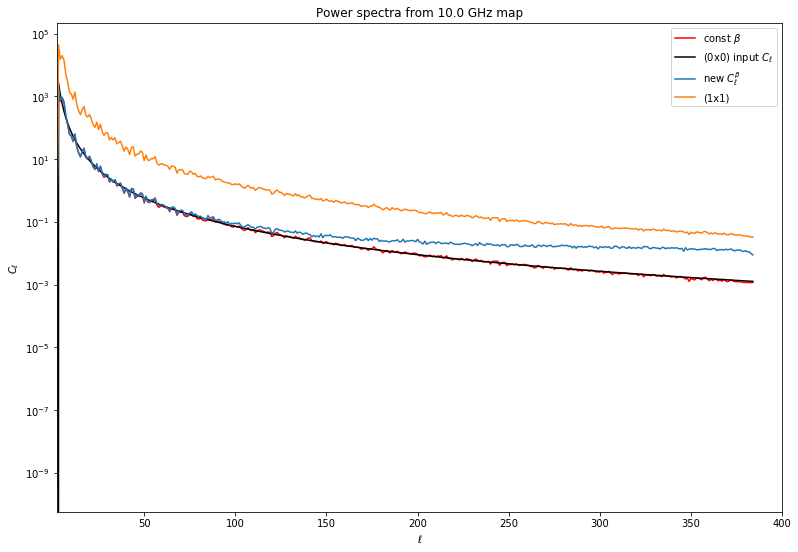

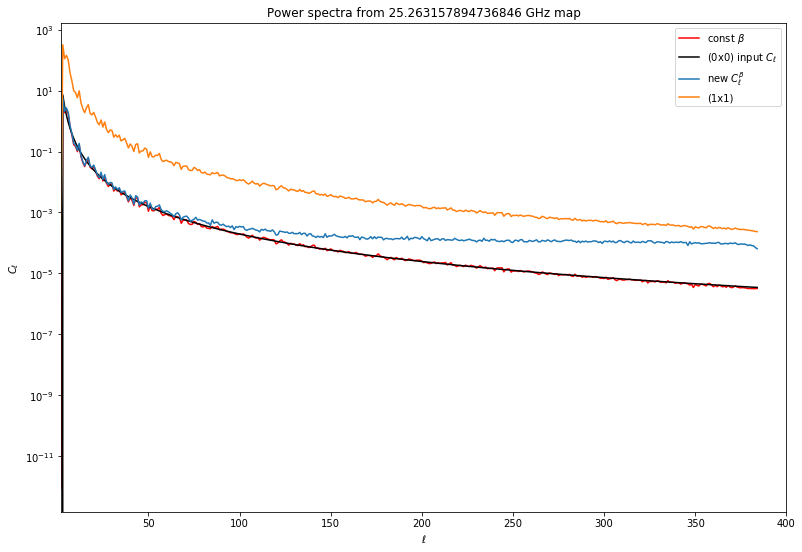

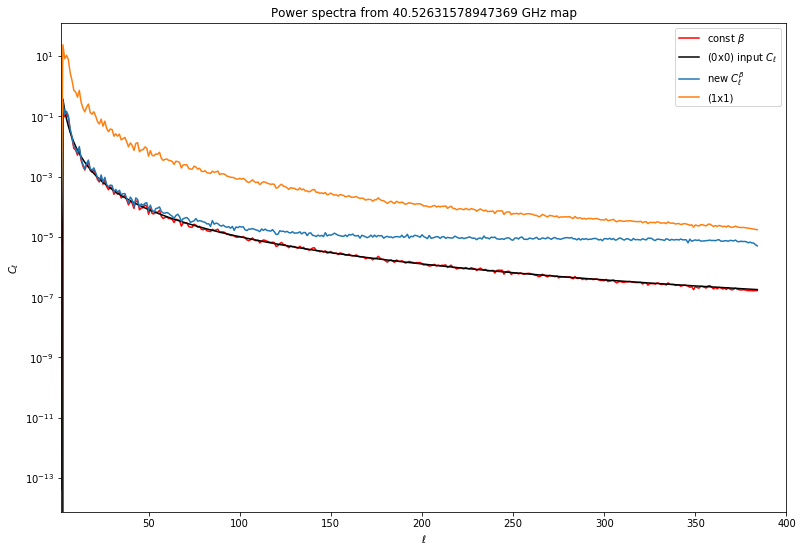

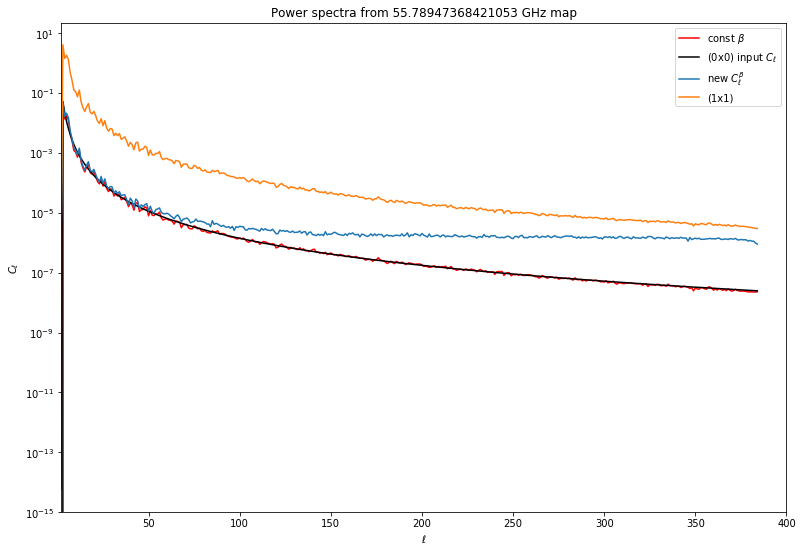

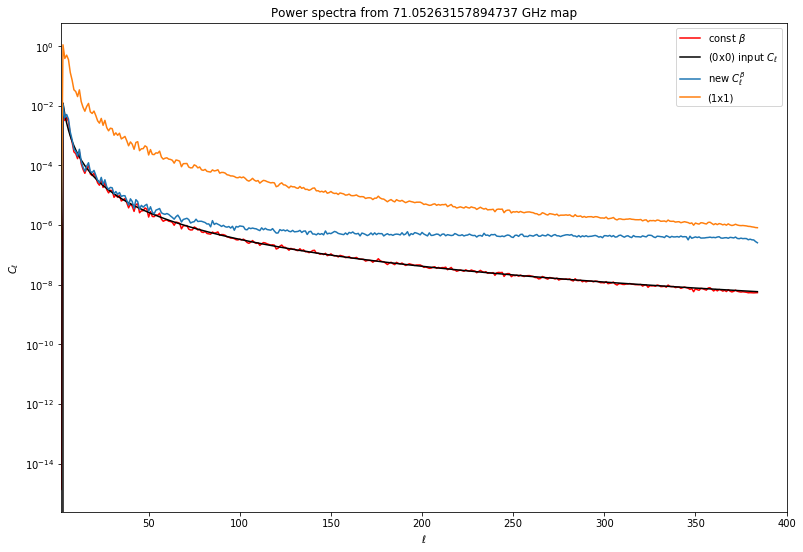

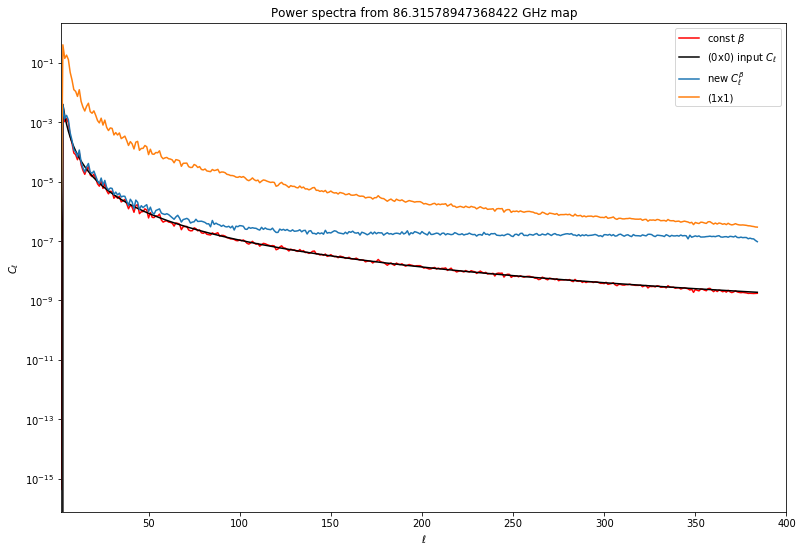

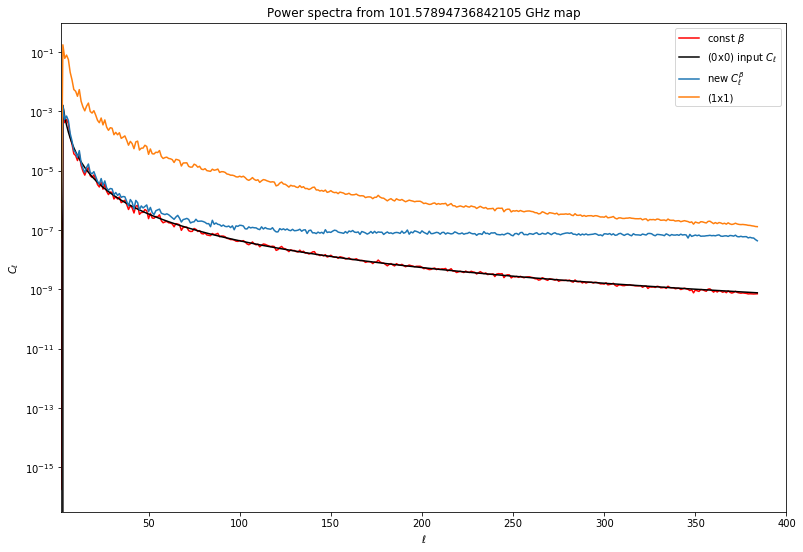

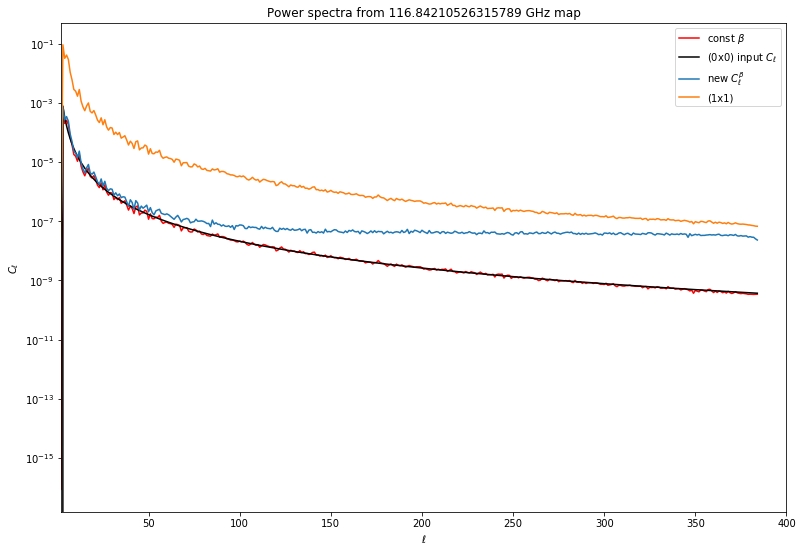

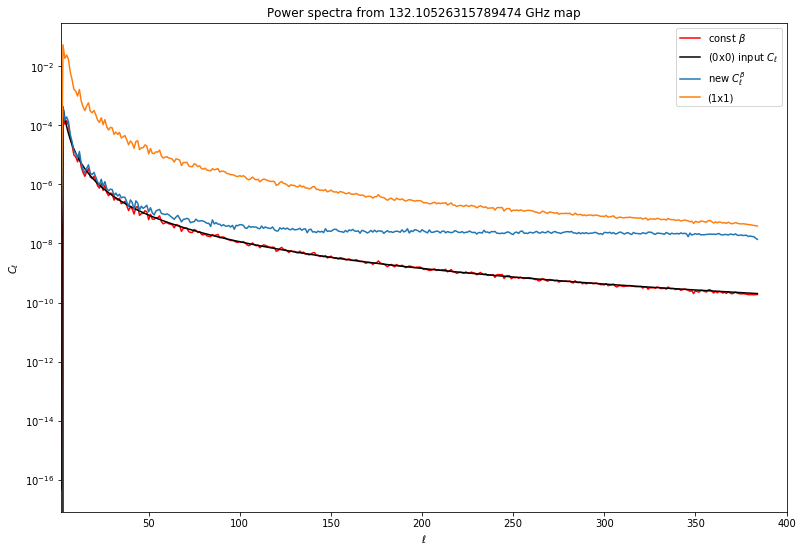

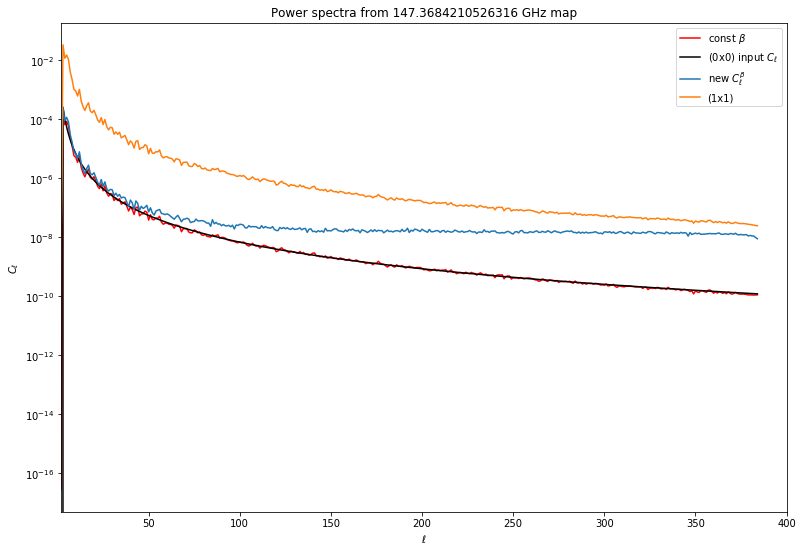

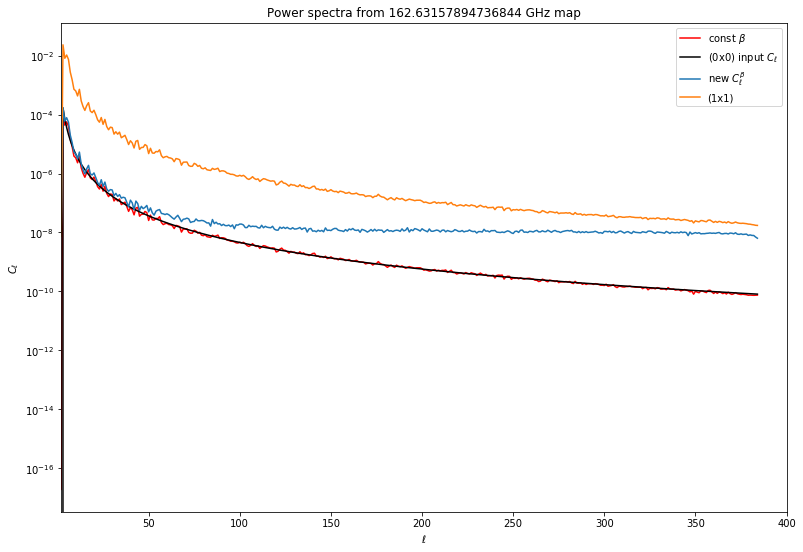

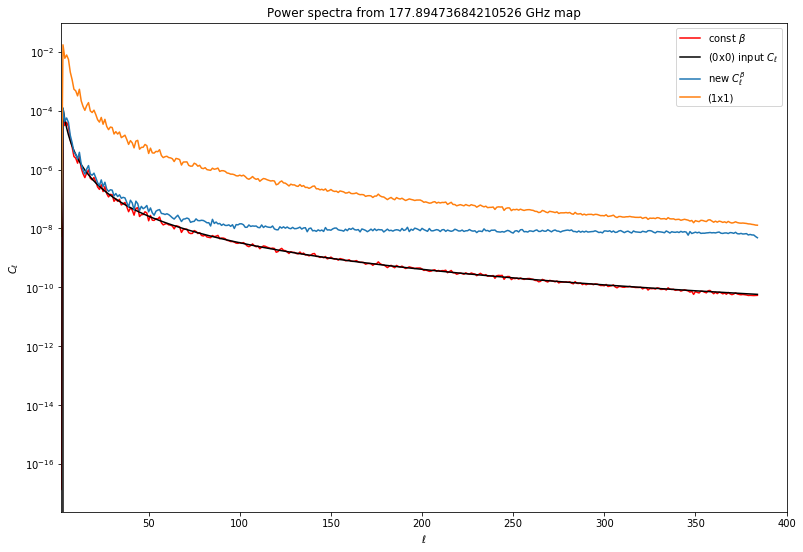

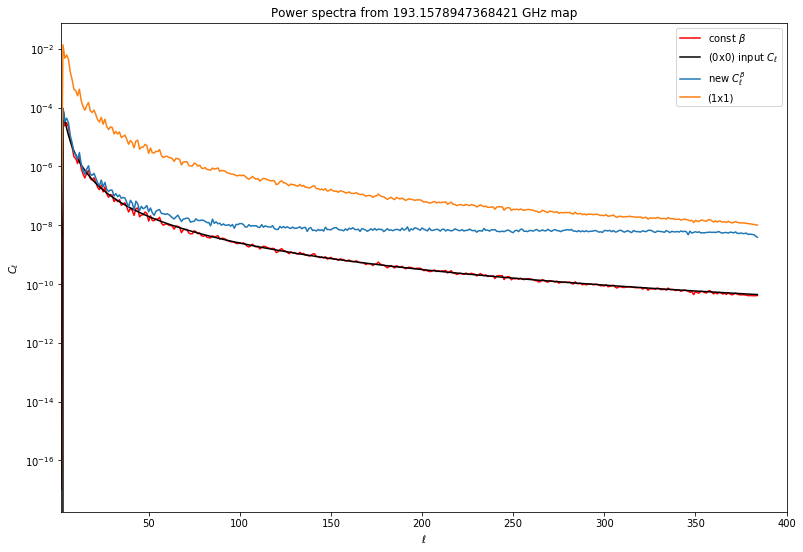

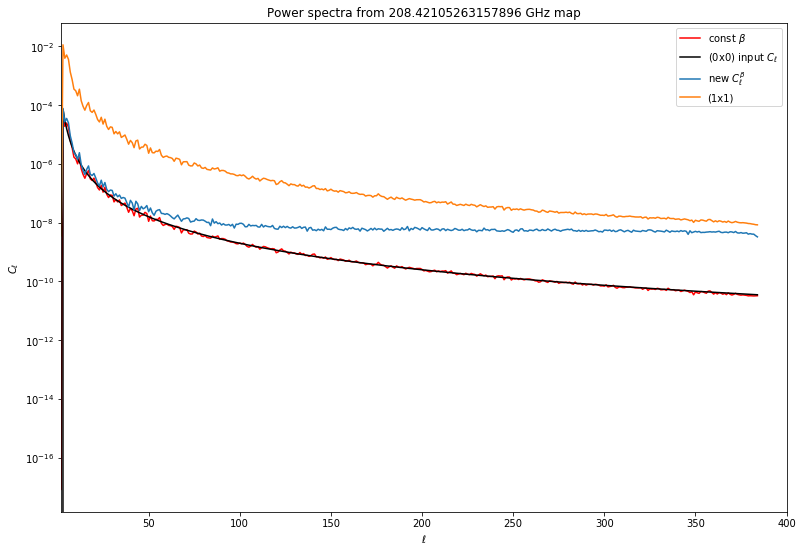

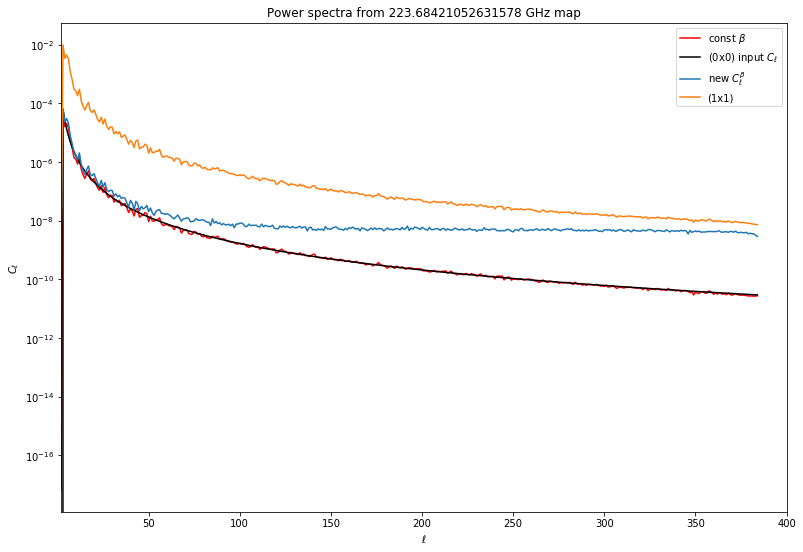

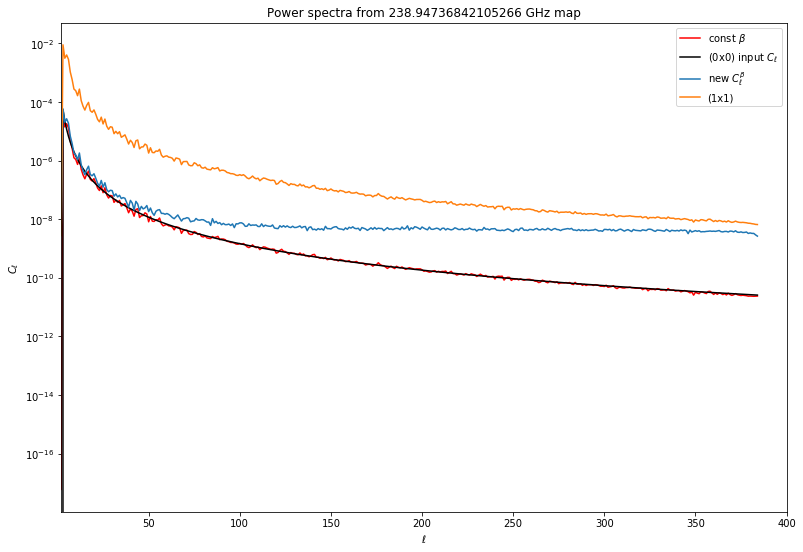

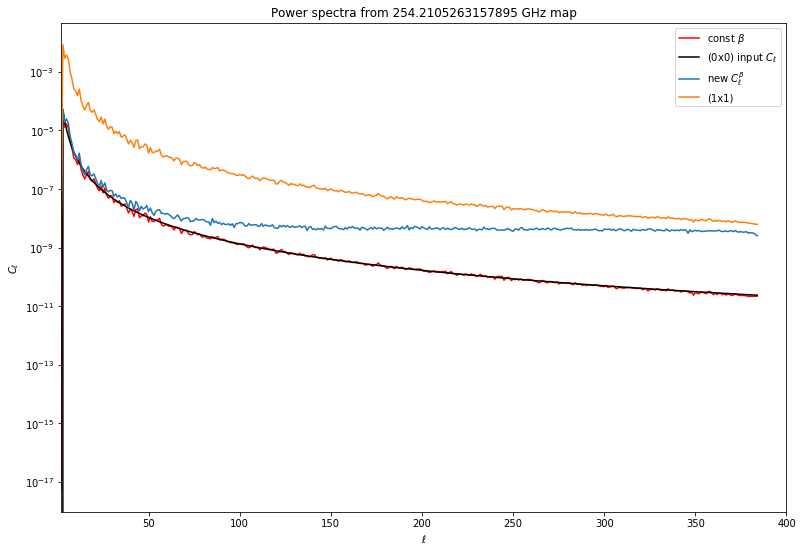

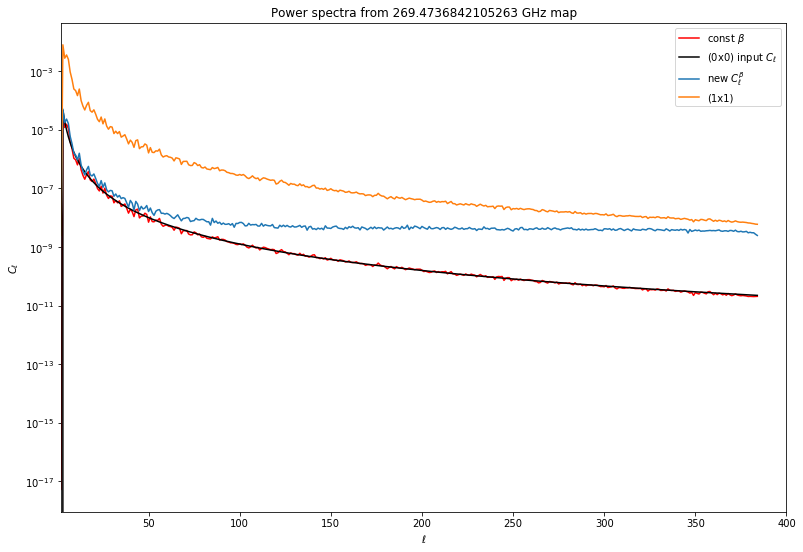

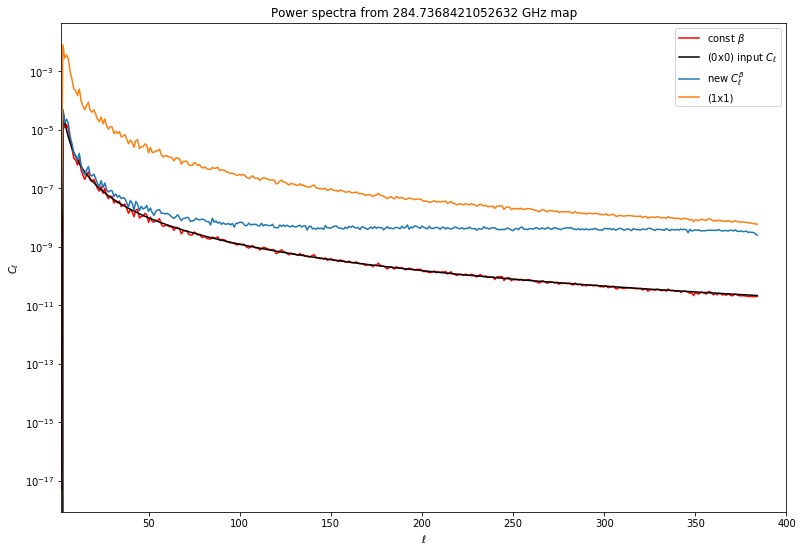

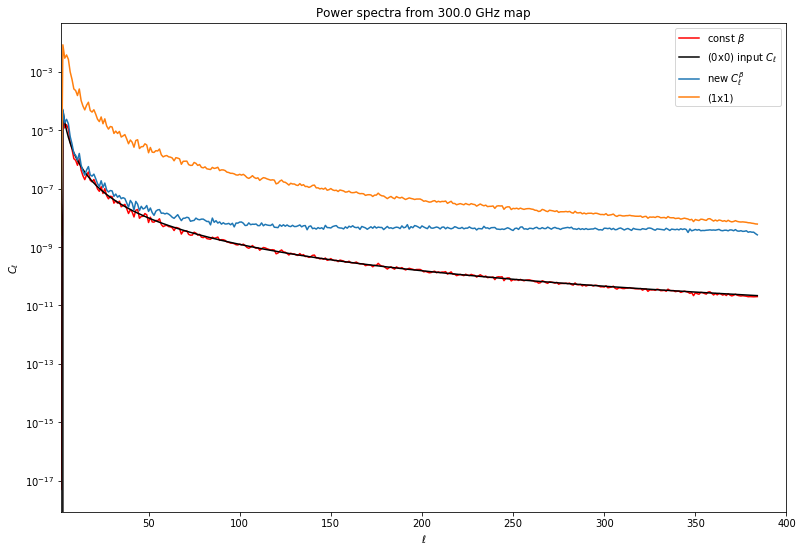

In [124]:
#plot power spectra
for k in range(20):
    #this takes the wigner sum and adds in the derivative terms out front
    moment1x1_k = log(freqs[k]/nu0)**2 * sed_scaling[k]**2 * wignersum 
    theory_cls = pcls*sed_scaling[k]**2        #input c_ell
    old_cls = hp.anafast(newmaps[k])           #the input c_ell
    new_cls = hp.anafast(newmaps_beta[k])      #the c_ell from constant c_ell from the beta


    figure(figsize=(13,9))
    semilogy(ells, old_cls, 'r', label=r"const $\beta$")
    semilogy(ells, theory_cls, 'k', label=r"(0x0) input $C_\ell $")
    semilogy(ells, new_cls, label=r"new $C_\ell^\beta$")
    semilogy(ells, moment1x1_k, label=r"(1x1)")
    title("Power spectra from " + str(1e-9*freqs[k]) + " GHz map" )
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    xlim(2,400)
    legend();

# Generating mean power spectra under many realisations
first with amplitude autospectrum

In [329]:
#define a function that generates an amplitude map given ells and a power for the power spectrum. Obtain its power
#spectrum and then generate a matrix of N realisations of each of the LMax C_ell
'''
[-------power spectrum 1-----------]
[-------power spectrum 2-----------]
               ...
[-------power spectrum N-----------]

''';

def amp_map(ell, alpha):
    input_cls = A_BB * powerlaw(ell, alpha)
    input_cls[0] = 0
    input_cls[1] = 0
    amp_map = hp.synfast(input_cls, nside, new=True, verbose=False)
    output_cls = hp.anafast(amp_map)
    return output_cls


N = 10
bigmat = zeros([N,384])


In [330]:
for i in range(N):
    #produce the cls to go into our realisation
    bigmat[i] += amp_map(ells, alpha_BB)
    if i%50 == 0:
        print("")
        print('step ' + str(i))
        print("")
    if i == N-1:
        print("")
        print("DONE!")
    #turn cls into a map
    #map_realisation = hp.synfast(bigmat[i], nside, new=True, verbose=False)
    #hp.mollview(map_realisation)


step 0


DONE!


In [211]:
mean_ps = np.zeros_like(bigmat[0])
#mean power spectrum coefficient at each ell is mean of the columns of bigmat
#is there a more efficient way of coding this? Doing the whole vector at once?
for i in range(len(bigmat[0])):
    mean_ps[i] += np.mean(bigmat[:,i])
    
mean_ps_new = np.mean(bigmat, 0)

    
#vector containning the standard deviation of these realisations at each value of ell
std_ps = np.zeros_like(bigmat[0])
for i in range(len(bigmat[0])):
    std_ps[i] += np.std(bigmat[:,i])
    
std_ps_new = np.std(bigmat,0)

<ErrorbarContainer object of 3 artists>

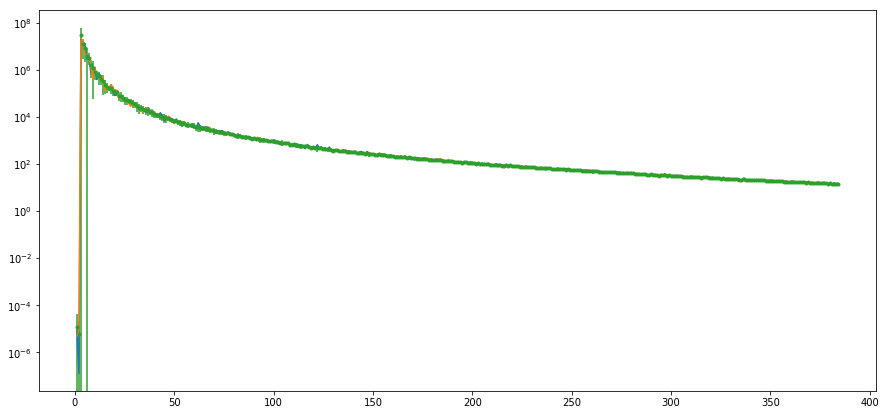

In [200]:
figure(figsize=(15,7))
semilogy(ells, bigmat[0])
semilogy(ells, bigmat[1])
#semilogy(ells, mean_ps)
errorbar(ells, mean_ps, yerr=2*std_ps, fmt='.')
#xlim(0,25)

In [149]:
#it's getting weird because the error bars are going negative? I think

In [ ]:
#do the same thing with a cross spectrum
